In [1]:
import random
import operator
import math
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

# Function to generate classification data
def generate_classification_data(n=100):
    data = []
    for _ in range(n):
        # Generate random x and y
        x = random.uniform(-1, 1)
        y = random.uniform(-1, 1)
        # Add noise
        noise = random.uniform(-1, 1)
        # Label 1 if inside circle, 0 otherwise
        label = 1 if x**2 + y**2 - noise < 1 else 0
        data.append((x, y, label))
    return np.array(data)

# Define a class to represent an individual (expression tree)
class Individual:
    def __init__(self, depth=5):
        self.tree = self.random_expression(depth)
        self.depth = depth

    def random_expression(self, depth):
        """ Recursively create random expressions """
        if depth == 0:
            terminal = random.choice(terminals)
            if terminal == 'x':
                return 'x'
            elif terminal == 'y':
                return 'y'
            else:
                return round(random.uniform(-1, 1), 1)
        func = random.choice(functions)
        if func in [math.sin, math.cos, math.exp]:
            return (func, self.random_expression(depth - 1))
        else:
            return (func, self.random_expression(depth - 1), self.random_expression(depth - 1))

    def evaluate(self, x, y):
        """ Evaluate the expression tree on given x and y values """
        return self._evaluate_recursive(self.tree, x, y)

    def _evaluate_recursive(self, node, x, y):
        try:
            if isinstance(node, (int, float)):
                return node
            elif node == 'x':
                return x
            elif node == 'y':
                return y
            elif isinstance(node, tuple):
                func = node[0]
                if func in [math.sin, math.cos, math.exp]:
                    value = self._evaluate_recursive(node[1], x, y)
                    # Avoid overflowed explosion in exponential if present
                    if func == math.exp and value > 700:
                        return float('inf')
                    return func(value)
                else:
                    a = self._evaluate_recursive(node[1], x, y)
                    b = self._evaluate_recursive(node[2], x, y)
                    # Deal with zero-division
                    if func == operator.truediv and abs(b) < 1e-6:
                        return 1
                    return func(a, b)
        except (OverflowError, ZeroDivisionError):
            return 1

    def fitness(self, data, alpha=1.0, beta=-0.05):
        """Complexity are weighted against accuracy"""
        class_0 = [self.evaluate(x, y) for x, y, label in data if label == 0]
        class_1 = [self.evaluate(x, y) for x, y, label in data if label == 1]

        # Class Mean
        mean_0 = np.mean(class_0)
        mean_1 = np.mean(class_1)

        # Class Variance
        var_0 = np.var(class_0)
        var_1 = np.var(class_1)

        # Fisher Criterion
        fisher_criterion = (mean_1 - mean_0)**2 / (var_1 + var_0 + 1e-6)  # Adding small value to avoid division by zero

        # Get tree complexity (number of nodes)
        complexity = self.tree_complexity()

        # Balance accuracy vs complexity
        fitness_score = alpha * fisher_criterion + beta * complexity 

        # Since we minimize in GP, return the negative of the fitness score
        return -fisher_criterion


    def tree_complexity(self):
        """ Calculate tree complexity as the total number of nodes """
        return self._tree_complexity_recursive(self.tree)

    def _tree_complexity_recursive(self, node):
        if isinstance(node, (int, float)) or node in ['x', 'y']:
            return 1
        elif isinstance(node, tuple):
            if len(node) == 2:
                return 1 + self._tree_complexity_recursive(node[1])
            elif len(node) == 3:
                return 1 + self._tree_complexity_recursive(node[1]) + self._tree_complexity_recursive(node[2])

    def mutate(self):
        """ Mutate the tree by changing a random part of it """
        self.tree = self.random_expression(depth=random.randint(1, self.depth))

    def crossover(self, other):
        """ Crossover with another individual by swapping a subtree """
        self.tree = other.tree

    def print_tree(self):
        """ Recursively print the tree structure """
        def _print_tree_recursive(node, indent=""):
            if isinstance(node, (int, float)) or node in ['x', 'y']:
                print(indent + str(node))
            elif isinstance(node, tuple):
                func = node[0].__name__ if callable(node[0]) else str(node[0])
                print(indent + func)
                _print_tree_recursive(node[1], indent + "  ")
                if len(node) > 2:
                    _print_tree_recursive(node[2], indent + "  ")

        print("Tree Structure:")
        _print_tree_recursive(self.tree)

    def get_expression(self):
        """ Convert the tree into a mathematical expression string """
        def _expression_recursive(node):
            if isinstance(node, (int, float)):
                return str(node)
            elif node == 'x':
                return 'x'
            elif node == 'y':
                return 'y'
            elif isinstance(node, tuple):
                func = node[0]
                if func in [math.sin, math.cos, math.exp]:
                    return f"{func.__name__}({_expression_recursive(node[1])})"
                else:
                    a = _expression_recursive(node[1])
                    b = _expression_recursive(node[2])
                    op = {operator.add: '+', operator.sub: '-', operator.mul: '*', operator.truediv: '/'}[func]
                    return f"({a} {op} {b})"
        return _expression_recursive(self.tree)

def genetic_programming(data, population_size=100, 
                        generations=50,
                        max_depth=7,
                        crossover_rate=0.8,
                        mutation_rate=0.3
                        ):
    population = [Individual(depth=random.randint(1, max_depth)) for _ in range(population_size)]
    fitness_progress = []
    avg_fitness_progress = []

    plt.figure()

    for gen in range(generations):
        population.sort(key=lambda ind: ind.fitness(data))

        best_ind = population[0]
        best_fitness = best_ind.fitness(data)
        fitness_progress.append(best_fitness)

        fitness_list = [p.fitness(data) for p in population]
        avg_fitness_progress.append(np.mean(fitness_list))
        
        # Dynamic Plotting for each generation
        clear_output(wait=True)
        plt.clf()
        
        # Plot the best fitness evolution
        plt.subplot(2, 2, 1)
        plt.plot(fitness_progress, label='Best Fitness')
        plt.title(f'Generation {gen+1}\nBest Fitness: {round(best_fitness, 1)}\nAvg Fitness: {round(np.mean(fitness_list), 1)}')
        plt.xlabel('Generation')
        plt.ylabel('Fitness Score')

        # Plot the avg fitness evolution
        plt.subplot(2, 2, 1)
        plt.plot(avg_fitness_progress, label='Avg Fitness')
        plt.legend()
        
        # Decision Boundary Plot between 2 classes
        plt.subplot(2, 2, 2)
        x_data, y_data, labels = zip(*data)
        x_range = np.linspace(min(x_data), max(x_data), 100)
        y_range = np.linspace(min(y_data), max(y_data), 100)
        xx, yy = np.meshgrid(x_range, y_range)
        zz = np.array([best_ind.evaluate(x, y) for x, y in zip(xx.ravel(), yy.ravel())]).reshape(xx.shape)
        plt.contourf(xx, yy, zz, levels=[-1, 0, 1], colors=['lightblue', 'lightcoral'], alpha=0.5)
        plt.scatter(x_data, y_data, c=labels, cmap='bwr', edgecolors='k')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title(f'Decision Boundary (Generation {gen})\n{best_ind.get_expression()}')

        plt.tight_layout()
        plt.draw()
        plt.pause(0.01)
        
        # Selection: Only top 50% best fitness survived 
        population = population[:population_size // 2]
        while len(population) < population_size:
            parent1, parent2 = random.sample(population, 2)
            child = Individual(depth=max_depth)
            # Crossover happened
            if random.random() < crossover_rate:
                child.crossover(parent2)
            # Mutation happened
            if random.random() < mutation_rate:
                child.mutate()
            population.append(child)

    return best_ind, fitness_progress

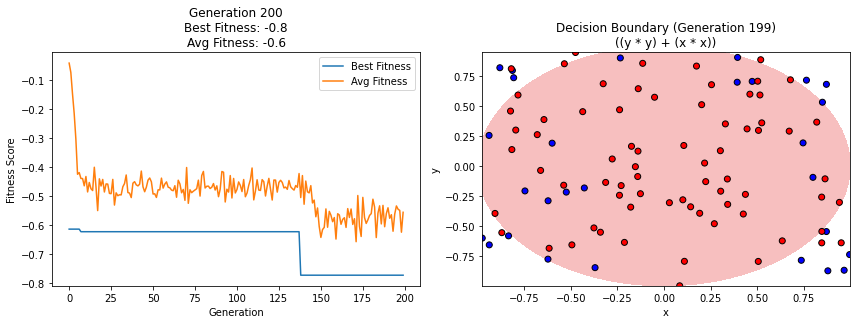

Best individual tree:
Tree Structure:
add
  mul
    y
    y
  mul
    x
    x
Best individual expression:
((y * y) + (x * x))
Best individual fitness: -0.7726627898448992


In [4]:
%matplotlib inline
from matplotlib import rcParams
rcParams['figure.figsize'] = 12, 8

# Define basic functions that will be used in the symbolic expressions
functions = [operator.add, operator.sub, operator.mul, operator.truediv]
terminals = ['x', 'y', 'const']

data = generate_classification_data()

# GP SUBROUTINES
best_individual, fitness_progress = genetic_programming(data, population_size=100, max_depth=2, generations=200)


print("Best individual tree:")
best_individual.print_tree()

print("Best individual expression:")
print(best_individual.get_expression())

print("Best individual fitness:", best_individual.fitness(data))